Dependency links:
- [rdflib](https://github.com/RDFLib/rdflib)
- [IMDbPY](https://github.com/alberanid/imdbpy)
- [pandas](http://pandas.pydata.org/)
- [matplotlib](https://matplotlib.org/)
- [numpy](https://www.numpy.org/)
- [unidecode](https://pypi.python.org/pypi/Unidecode)

# Selecting Film Data out of All DBTropes Data

**TODO: need to make this session into a makefile.**

DBTropes Data can be downloaded [here](http://dbtropes.org/static/dbtropes.zip). Unzipped file is (re?)named as **dbtropes.nt**.

The film data selection step should be done from the command line (too much pressure on Jupyter notebook), using the script *extract_film_data.py*:

```python

# Extracting all film type data
# Subject format: http://dbtropes.org/resource/Film/[Film Title]

import re

def main():
    film_data = open('film_data.nt', 'w')
    with open('dbtropes.nt') as rawfile:
        for line in rawfile:
            if re.match("<http://dbtropes.org/resource/Film/", line):
                film_data.write(line)
        film_data.close()

if __name__ == "__main__":
    main()
    
```

# Parsing the Film Data Set

The result of data parsing is pickeled. Start from the pickle or SQL database, see next session.

In [ ]:
# # This step takes a while. Alternative: load film_trope_dict.pkl, or use tv_tropes.db.

# from __future__ import print_function
# import rdflib

# g = rdflib.Graph()
# g.parse("film_data.nt", format="nt")

# len(g)

In [ ]:
# import re

# film_trope_dict = {}


# for t_sub, t_obj in g.subject_objects(predicate=rdflib.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type')):
#     title = ''
#     trope = ''
#     try:
#         title = re.match('http://dbtropes.org/resource/Film/([^/]*)', t_sub).groups()[0]
#         trope = re.match('http://dbtropes.org/resource/Main/([^/]*)', t_obj).groups()[0]
#         if title in film_trope_dict:
#             film_trope_dict[title].append(trope)
#         else:
#             film_trope_dict[title] = [trope]
#     except Exception:
#         pass


# Preparing the Database for Downstream Analysis

## Trope Appearance Database

In [2]:
from __future__ import print_function # Because the code was moved from Python 3 to 2
import re

import pickle
import sqlite3

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline


In [ ]:
## write python dict to film_trope_dict.pkl

# output = open('film_trope_dict_python2.pkl', 'wb')
# pickle.dump(film_trope_dict, output, protocol=2) # default protocol is 3 in Python 3, not supported in Python 2
# output.close()

In [2]:
# read python dict back from the file
pkl_file = open('film_trope_dict_python2.pkl', 'rb')
film_trope_dict = pickle.load(pkl_file)
pkl_file.close()

In [3]:
def read_dict_to_df(input_dict):
    '''Take a dict of {title : [list of tropes in this title], 
       return a DataFrame of all film-trope pairs with an arbituary index.
       Each row of the DataFrame: autoincremented index, name of title, name of trope.'''
    df = pd.DataFrame.from_dict(input_dict, orient ="index").sort_index().stack().reset_index(level=1, drop=True).reset_index()    
    df.columns = ['title', 'trope']
    return df

# This database is the foundation of all analysis.
film_trope_df = read_dict_to_df(film_trope_dict)
film_trope_df.head()

,title,trope
0,ABeautifulMind,ScienceRelatedMemeticDisorder
1,ABeautifulMind,HollywoodNerd
2,ABeautifulMind,TheBigBoard
3,ABeautifulMind,MadMathematician
4,ABeautifulMind,EEqualsMCHammer


In [4]:
# Some string manipulation helper functions

import unidecode
def strip_lowercase(text):
    '''Strip spaces, capitalization, punctuation and accents from string, esp. movie titles.'''
    text = unidecode.unidecode(text) # dependency: unidecode
    return re.sub(r'[^\w]', '', text).lower()

def add_space(text):
    '''Add spaces between captalized words, for better display of trope and movie names in the output.
       Spaces should be added just before the strings need to be outputted.'''
    return re.sub(r"\B([A-Z]+)", r" \1", text)

In [5]:
pd.options.mode.chained_assignment = None # supress pd SettingWithCopyWarning
film_trope_df['stripped_title'] = film_trope_df['title'].map(strip_lowercase, na_action='ignore')
film_trope_df['stripped_trope'] = film_trope_df['trope'].map(strip_lowercase, na_action='ignore')
film_trope_df.head()

,title,trope,stripped_title,stripped_trope
0,ABeautifulMind,ScienceRelatedMemeticDisorder,abeautifulmind,sciencerelatedmemeticdisorder
1,ABeautifulMind,HollywoodNerd,abeautifulmind,hollywoodnerd
2,ABeautifulMind,TheBigBoard,abeautifulmind,thebigboard
3,ABeautifulMind,MadMathematician,abeautifulmind,madmathematician
4,ABeautifulMind,EEqualsMCHammer,abeautifulmind,eequalsmchammer


In [ ]:
# # Make a SQL table of all title-trope pairs. Table name: 'title_trope'

# import sqlite3
# conn = sqlite3.connect('tv_tropes.db')
# film_trope_df.to_sql('title_trope', conn, if_exists='fail', index=False, index_label=None, chunksize=None)
# conn.close()

In [6]:
# Read SQL table and try out some queries

conn = sqlite3.connect('tv_tropes.db')
# cur = conn.cursor()  # Do not need cursor with pd.read_sql_query

# query = '''SELECT title, trope FROM title_trope
#            WHERE title = "TheMatrix"
#            LIMIT 10;'''

query = 'SELECT * FROM title_trope LIMIT 10'
toy_df = pd.read_sql_query(query, conn)

# Always close Connection and Cursor objects that are open when done.
# This prevents the SQLite database from being locked, which may lead to update failure and errors.
conn.close()

toy_df

,title,trope,stripped_title,stripped_trope
0,ABeautifulMind,ScienceRelatedMemeticDisorder,abeautifulmind,sciencerelatedmemeticdisorder
1,ABeautifulMind,HollywoodNerd,abeautifulmind,hollywoodnerd
2,ABeautifulMind,TheBigBoard,abeautifulmind,thebigboard
3,ABeautifulMind,MadMathematician,abeautifulmind,madmathematician
4,ABeautifulMind,EEqualsMCHammer,abeautifulmind,eequalsmchammer
5,ABeautifulMind,TheReveal,abeautifulmind,thereveal
6,ABeautifulMind,Hallucinations,abeautifulmind,hallucinations
7,ABeautifulMind,GoodWithNumbers,abeautifulmind,goodwithnumbers
8,ABeautifulMind,TheLoinsSleepTonight,abeautifulmind,theloinssleeptonight
9,ABeautifulMind,ShoutOut,abeautifulmind,shoutout


# Movie Info Database

In [7]:
def run_query(query, sql_db='tv_tropes.db', index_col=None, coerce_float=True,
              params=None, parse_dates=None, chunksize=None):
    '''Takes a SQL query(a string) and a database (a string of 'database_name.db') in which query 
       should be performed, run the query and return the query result as a pandas DataFrame.
       Can use the same args as pd.read_sql_query().'''
    
    if not isinstance(query, basestring):
        raise TypeError('query must be a string')
    conn = sqlite3.connect(sql_db)
    df = pd.read_sql_query(query, conn, index_col=index_col, coerce_float=coerce_float, 
                           params=params, parse_dates=parse_dates, chunksize=chunksize)
    conn.close
    return df

In [8]:
# Extract omdb table from bokeh sample database movies.db

query = '''SELECT * FROM omdb;'''
omdb_df = run_query(query, 'movies.db')
omdb_df.head(3)

,ID,imdbID,Title,Year,Rating,Runtime,Genre,Released,Director,Writer,Cast,Metacritic,imdbRating,imdbVotes,Language,Country,Awards,lastUpdated,Oscars
0,4972,tt0004972,The Birth of a Nation,1915,Not Rated,165.0,"Drama, History, Romance",1915-03-03,D.W. Griffith,"Thomas F. Dixon Jr. (adapted from his novel: ""...","Lillian Gish, Mae Marsh, Henry B. Walthall, Mi...",NaN,6.9,13793.0,None,USA,1 win.,2014-03-31 02:13:23.440000000,0
1,6206,tt0006206,Les vampires,1915,Not Rated,399.0,"Action, Adventure, Crime",1915-11-13,Louis Feuillade,Louis Feuillade,"Musidora, Édouard Mathé, Marcel Lévesque, Jean...",NaN,6.6,2502.0,French,France,1 nomination.,2014-03-07 00:05:37.133000000,0
2,6864,tt0006864,Intolerance: Love's Struggle Throughout the Ages,1916,Not Rated,197.0,"Drama, History",1916-09-05,D.W. Griffith,"D.W. Griffith (scenario), Anita Loos (titles)","Lillian Gish, Spottiswoode Aitken, Mary Alden,...",NaN,8.0,8673.0,None,USA,1 win.,2014-03-27 01:05:04.920000000,0


In [ ]:
omdb_df['stripped_title'] = omdb_df['Title'].map(strip_lowercase, na_action='ignore')
omdb_df.head(3)

In [ ]:
# # Make a SQL table of omdb movie info in tv_tropes.db. Table name: 'omdb'

# conn = sqlite3.connect('tv_tropes.db')
# omdb_df.to_sql('omdb', conn, if_exists='fail', index=False, index_label=None, chunksize=None)
# conn.close()

In [9]:
# Getting a list of all possible genres
# Caution: this list has an u'Adult' genre

# def parse_genres(genres):
#     '''Take a string of genres separated by ', ', return a list of genres'''
#     regex = re.compile(r'([\w-]+)(?:$|, )')
#     return re.findall(regex, genres)

def split_str(input_str):
    '''Take a string with the format 'A, B, C', return a list ['A', 'B', 'C']/'''
    regex = re.compile(r'([\w-]+)(?:$|, )')
    return re.findall(regex, genres)

def get_genre_list():
    '''Return a list of all possible genres in omdb table.'''
    result = set()
    q = 'SELECT Genre FROM omdb;'
    temp_df = run_query(q, 'tv_tropes.db')
    for g in temp_df['Genre'].dropna().unique():
        result.update(re.split(', ', g))
    return list(result)

GENRE_LIST = get_genre_list()
GENRE_LIST.sort()
GENRE_LIST.remove(u'Adult')  # not going to deal with this
print(GENRE_LIST)

[u'Action', u'Adventure', u'Animation', u'Biography', u'Comedy', u'Crime', u'Documentary', u'Drama', u'Family', u'Fantasy', u'Film-Noir', u'History', u'Horror', u'Music', u'Musical', u'Mystery', u'News', u'Romance', u'Sci-Fi', u'Short', u'Sport', u'Thriller', u'War', u'Western']


## (Now Obsolete) using IMDB 5000 Database
Originally I planned to use IMDbPy API, but it turned out to be not as straight forward as I expected. I then decided to use the [Kaggle IMDB 5000 Movie Database](https://www.kaggle.com/deepmatrix/imdb-5000-movie-dataset) instead. 

The database, a csv file **movie_metadata.csv**, comes from web scrapping. 28 column names:

"movie_title" "color" "num_critic_for_reviews" "movie_facebook_likes" "duration" "director_name" "director_facebook_likes" "actor_3_name" "actor_3_facebook_likes" "actor_2_name" "actor_2_facebook_likes" "actor_1_name" "actor_1_facebook_likes" "gross" "genres" "num_voted_users" "cast_total_facebook_likes" "facenumber_in_poster" "plot_keywords" "movie_imdb_link" "num_user_for_reviews" "language" "country" "content_rating" "budget" "title_year" "imdb_score" "aspect_ratio"

**Note: sadly, later I found this database was smaller than Bokeh movie sample database.**

In [ ]:
# imdb5000 = pd.read_csv('movie_metadata.csv', encoding='utf-8')
# imdb5000.head(10)

In [ ]:
# movie_info_df = imdb5000[['movie_title', 'genres', 'title_year', 'imdb_score', 'director_name', 
#                            'gross', 'budget', 'content_rating', 'movie_imdb_link']]
# movie_info_df.head()

In [ ]:
# # Some imdb helper functions

# def find_imdb_id(link):
#     '''Take a string of an IMDB link url, and return the IMDB ID of this movie (tt[\d]*7)'''
#     regex = re.compile(r':?title/(tt[\d]*)/\?ref')
#     return re.findall(regex, link)[0]

# def parse_genres_5000(genres):
#     '''Take a string of genres separated by |, return a list of genres'''
#     regex = re.compile(r'([\w-]+)(?:$|\|)')
#     return re.findall(regex, genres)

In [ ]:
# movie_info_df['imdb_id'] = movie_info_df['movie_imdb_link'].map(find_imdb_id, na_action='ignore')
# movie_info_df['stripped_title'] = movie_info_df['movie_title'].map(strip_lowercase, na_action='ignore')

# movie_info_df.drop('movie_imdb_link', axis=1, inplace=True)
# movie_info_df.set_index('imdb_id', inplace=True)
# movie_info_df.head()

In [ ]:
# # Make a SQL table of movie info. Table name: 'movie_info'

# conn = sqlite3.connect('tv_tropes.db')
# movie_info_df.to_sql('movie_info', conn, if_exists='fail', index=False, index_label=None, chunksize=None)
# conn.close()

In [ ]:
# # Test: read SQL table of movie info

# conn = sqlite3.connect('tv_tropes.db')

# query = 'SELECT * FROM movie_info LIMIT 3;'
# print(pd.read_sql_query(query, conn))

# # Always close Connection and Cursor objects that are open when done.
# # This prevents the SQLite database from being locked, which may lead to update failure and errors.
# conn.close()

In [ ]:
# # Join tables: film_trope, movie_info

# query = '''SELECT * FROM title_trope as t
#            JOIN movie_info as m
#            ON t.stripped_title = m.stripped_title;'''
# movie_joined = run_query(query)
# len(movie_joined['title'].unique())

# # Output: 2143 (titles sucessfully joined)
# # Bokeh sample database is able to join 3840

# (Now Obsolete) Using IMDbPY

In [ ]:
# # In case imdb is not imported correctly
# # In python CLI, import imdb, print imdb.__path__, and add to sys.path in jupyter

# import sys
# sys.path.append() # insert module path
# print(sys.path)

In [ ]:
# # The problem with IMDbPY is, it is difficult to get the movie object from the title.
# # And sometime an error of 'How did you gey here?' will occur

# from imdb import IMDb
    
# # Create the object that will be used to access the IMDb's database.
# ia = IMDb(accessSystem='http')

In [ ]:
# the_matrix = ia.get_movie('0133093')
# #print the_matrix['director']


In [ ]:
# print(the_matrix['title'], the_matrix['year'], the_matrix['genre'], the_matrix['rating'], the_matrix['top 250 rank'])

# Plotting

In [3]:
# Matplotlib style config
plt.rcParams.update(plt.rcParamsDefault) # reset
plt.style.use('seaborn-pastel')

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams.update({'figure.autolayout': True}) # Auto resize

# plt.rcParams['figure.figsize'] = 8, 5
# plt.rcParams['font.size'] = 10
# plt.rcParams['axes.labelsize'] = 10
# plt.rcParams['axes.labelweight'] = 'bold'
# plt.rcParams['xtick.labelsize'] = 8
# plt.rcParams['ytick.labelsize'] = 8
# plt.rcParams['legend.fontsize'] = 10
# plt.rcParams['figure.titlesize'] = 12

In [11]:
plt.plot([1,2,3,4], [1,4,9,16])
plt.plot([1,2,3,4], [2,4,8,10])
plt.plot([1,2,3,4], [4,3,2,1])

## Popular Tropes in Each Genre

In [12]:
# SQL dababase: tv_tropes.db
# movie-trope table: 'title_trope'
# movie info table: 'omdb'

def get_trope_freq_by_genre(genre_exp):
    '''Return a pd.DataFrame containing counts and frequencies of trope appearance.
       genre_exp: a single string (eg. '%Action%') used to match genre info, omdb.Genre LIKE genre_exp.
       genre_exp can be writted to match multiple genres (in alphabetical order) in the same movie, 
       eg. '%Action%Horror%'
       Result DataFrame columns: ['trope', 'stripped_trope', 'trope_count', 'trope_freq'], 
       sorted by trope_count (desc).    
    '''    
    # Query explanations:
    # temp_counted: join title_trope and omdb tables on stripped_title, then filter results by the give genre.
    # temp_result: calculate trope_count based on temp_filtered
    # outmost select: calculate trope_freq based on temp_result
    genre_query = '''WITH temp_counted AS
                         (SELECT trope, stripped_trope, COUNT(stripped_trope) as trope_count
                         FROM (SELECT * FROM title_trope AS t
                               JOIN omdb AS o
                               ON t.stripped_title = o.stripped_title
                               WHERE o.Genre LIKE ?) AS temp_filtered
                         GROUP BY stripped_trope
                         ORDER BY trope_count DESC)
                     SELECT *, trope_count * 1.0 / (SELECT SUM(trope_count) from temp_counted) as trope_freq
                     FROM temp_counted; 
                 '''
    return run_query(genre_query, params=(genre_exp,))

In [13]:
all_genres_df = get_trope_freq_by_genre('%')
all_genres_df.head()

,trope,stripped_trope,trope_count,trope_freq
0,ShoutOut,shoutout,1107,0.005779
1,ChekhovsGun,chekhovsgun,791,0.004129
2,DeadpanSnarker,deadpansnarker,647,0.003377
3,OhCrap,ohcrap,636,0.003320
4,Foreshadowing,foreshadowing,596,0.003111


In [18]:
# all_genres_df.to_csv('internal_csv/all_genres_freq.csv')

In [ ]:
all_genres_df['trope_count'].describe()

In [ ]:
all_genres_df['trope_count'].quantile([0.9, 0.99, 0.999])

In [ ]:
print('Min. counts at 0.9 quantile: ', len(all_genres_df[all_genres_df['trope_count'] > 23]))
print('Min. counts at 0.99 quantile: ', len(all_genres_df[all_genres_df['trope_count'] > 122]))
print('Min. counts at 0.999 quantile: ', len(all_genres_df[all_genres_df['trope_count'] > 385]))

In [ ]:
print('Top 20 Tropes of All:')
#print(', '.join(t for t in all_genres_df['trope'][:20]))
print(list(all_genres_df['trope'][:20]))
print('These 20 Tropes account for {} of all trope counts.'.format(all_genres_df['trope_freq'][:20].sum()))

In [ ]:
action_df = get_trope_freq_by_genre('%Action%')
action_df.head()

In [19]:
# GENRE_LIST: a list of all possible genres

def count_all_genres(genre_list = GENRE_LIST):
    dfs = {}
    dfs['all_genres'] = get_trope_freq_by_genre('%')
    print('all_genres is counted')
    
    for genre in genre_list:
        genre_exp = '%{}%'.format(genre)
        try:
            dfs[genre] = get_trope_freq_by_genre(genre_exp)
            print('{} is counted'.format(genre))
        except TypeError:
            print('{} is not found'.format(genre))
    return dfs

In [20]:
# This takes a couple of minutes
by_genre_dfs = count_all_genres(GENRE_LIST)

all_genres is counted
Action is counted
Adventure is counted
Animation is counted
Biography is counted
Comedy is counted
Crime is counted
Documentary is counted
Drama is counted
Family is counted
Fantasy is counted
Film-Noir is counted
History is counted
Horror is counted
Music is counted
Musical is counted
Mystery is counted
News is not found
Romance is counted
Sci-Fi is counted
Short is counted
Sport is counted
Thriller is counted
War is counted
Western is counted


In [21]:
# Since genre 'News' is not found in the overlap of title_trope and omdb, delete from GENRE_LIST

GENRE_LIST.remove(u'News')
GENRE_LIST

[u'Action',
 u'Adventure',
 u'Animation',
 u'Biography',
 u'Comedy',
 u'Crime',
 u'Documentary',
 u'Drama',
 u'Family',
 u'Fantasy',
 u'Film-Noir',
 u'History',
 u'Horror',
 u'Music',
 u'Musical',
 u'Mystery',
 u'Romance',
 u'Sci-Fi',
 u'Short',
 u'Sport',
 u'Thriller',
 u'War',
 u'Western']

In [22]:
# # save to csv for using in another notebook, or loading back only on genre

# for g in (GENRE_LIST + ['all_genres']):
#     by_genre_dfs[g].to_csv('internal_csv/{}_freq.csv'.format(g))
#     print('{} is written to csv'.format(g))

Action is written to csv
Adventure is written to csv
Animation is written to csv
Biography is written to csv
Comedy is written to csv
Crime is written to csv
Documentary is written to csv
Drama is written to csv
Family is written to csv
Fantasy is written to csv
Film-Noir is written to csv
History is written to csv
Horror is written to csv
Music is written to csv
Musical is written to csv
Mystery is written to csv
Romance is written to csv
Sci-Fi is written to csv
Short is written to csv
Sport is written to csv
Thriller is written to csv
War is written to csv
Western is written to csv


In [6]:
# # Load from csv
GENRE_LIST = [u'Action',
             u'Adventure',
             u'Animation',
             u'Biography',
             u'Comedy',
             u'Crime',
             u'Documentary',
             u'Drama',
             u'Family',
             u'Fantasy',
             u'Film-Noir',
             u'History',
             u'Horror',
             u'Music',
             u'Musical',
             u'Mystery',
             u'Romance',
             u'Sci-Fi',
             u'Short',
             u'Sport',
             u'Thriller',
             u'War',
             u'Western']

by_genre_dfs = {}
for g in (GENRE_LIST + ['all_genres']):
    try:
        by_genre_dfs[g] = pd.read_csv('internal_csv/{}_freq.csv'.format(g))
        print('{} is loaded from csv'.format(g))
    except IOError:
        print('Cannot find {}_freq.csv'.format(g))

Action is loaded from csv
Adventure is loaded from csv
Animation is loaded from csv
Biography is loaded from csv
Comedy is loaded from csv
Crime is loaded from csv
Documentary is loaded from csv
Drama is loaded from csv
Family is loaded from csv
Fantasy is loaded from csv
Film-Noir is loaded from csv
History is loaded from csv
Horror is loaded from csv
Music is loaded from csv
Musical is loaded from csv
Mystery is loaded from csv
Romance is loaded from csv
Sci-Fi is loaded from csv
Short is loaded from csv
Sport is loaded from csv
Thriller is loaded from csv
War is loaded from csv
Western is loaded from csv
all_genres is loaded from csv


In [ ]:
# Plot testing
# GENRE_LIST: a list of all possible genres

def plot_top_n_freq(df, n=10, xlabel='Trope Frequency', title=''):
    fig, ax = plt.subplots()
    y_pos = np.arange(n)
    ax.barh(y_pos, df.iloc[:n]['trope_freq'])
    ax.set_yticks(y_pos)
    ax.set_yticklabels(df.iloc[:n]['trope'])
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    
for genre in GENRE_LIST[:3]:
    plot_top_n_freq(by_genre_dfs[genre], title = 'Top 10 Tropes in the {} Genre'.format(genre))

In [9]:
# Prepare data for plotting a heatmap of how frequent the overall top tropes are in each genre
def get_genre_heatmap_data(n=20):
    '''Generate data for plotting a heatmap.
       Tropes selected are top n tropes over all genres.
       Their freq in all_genres and each individual genre is summarized in the DataFrame returned.'''

    heatmap_df = by_genre_dfs['all_genres'].loc[:(n-1), ['trope', 'trope_freq']]
    heatmap_df.columns = ['trope', 'All_genres']

    for genre in GENRE_LIST:    
        heatmap_df[genre] = pd.merge(heatmap_df, by_genre_dfs[genre], 
                                     left_on='trope', right_on='trope', how='left')['trope_freq']
    heatmap_df.set_index('trope', inplace=True)
    return heatmap_df
    
heatmap_df = get_genre_heatmap_data(n=20)

In [10]:
heatmap_df.head()

,All_genres,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
trope,,,,,,,,,,,,,,,,,,,,,
ShoutOut,0.005779,0.005011,0.005059,0.006454,0.004381,0.007177,0.005137,0.006324,0.005297,0.007370,...,0.007167,0.006853,0.005210,0.005218,0.006201,0.008130,0.007324,0.005183,0.003524,0.005907
ChekhovsGun,0.004129,0.004258,0.004096,0.004107,0.001314,0.004057,0.004891,0.003162,0.004041,0.003606,...,0.002718,0.001654,0.006122,0.003293,0.003734,NaN,0.002746,0.005800,0.001244,0.003657
DeadpanSnarker,0.003377,0.002613,0.002786,0.002053,0.003797,0.004458,0.003470,0.003953,0.003503,0.003998,...,0.004572,0.005671,0.003517,0.005673,0.002334,NaN,0.005188,0.002685,0.002280,0.004219
OhCrap,0.003320,0.003751,0.003564,0.003520,0.003943,0.003106,0.003880,0.003162,0.002952,0.003685,...,0.002101,0.001890,0.003647,0.001621,0.003634,0.004065,0.004883,0.003867,0.002695,0.002813
Foreshadowing,0.003111,0.002659,0.002642,0.002933,0.004089,0.002274,0.003170,0.003953,0.003614,0.002744,...,0.002595,0.002599,0.005275,0.002837,0.003101,NaN,0.004272,0.004135,0.002902,0.004501


In [32]:
print(heatmap_df.dropna(how='any').values.min(), heatmap_df.dropna(how='any').values.max())

0.000790513833992 0.00813008130081


In [41]:
# Plot interactive Heatmap of overall top tropes in each genre
# WTF is this coloring? Why is it not using all the colors??

import plotly.plotly as py
import plotly.graph_objs as go

data = [go.Heatmap(z=heatmap_df.values.tolist(), zmin=0.0007, zmax=0.008,
                   colorscale='gist_heat_r', reversescale=True)]
py.iplot(data, filename='freq_by_genre_heatmap')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~pzplotly/0 or inside your plot.ly account where it is named 'freq_by_genre_heatmap'


/opt/conda/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.



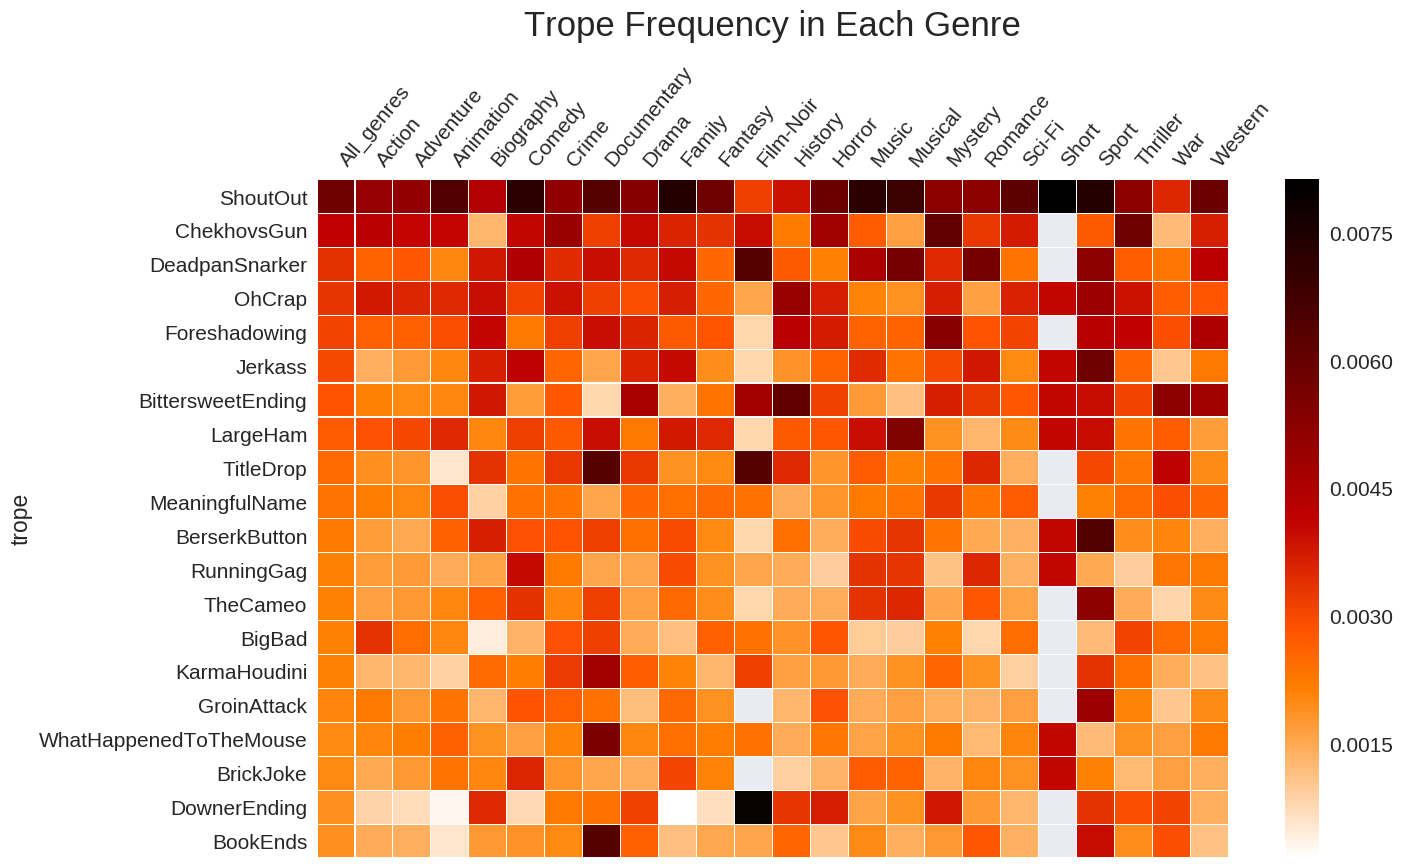

In [40]:
# Plot Heatmap of overall top tropes in each genre
# use output_notebook for Jupyter, output_file for saving pictures

import seaborn as sns

def plot_heatmap(df, title='', title_offset=1.2, size=(15, 9), path=None):
    '''Plot a heatmap from the given DataFrame (should be in a pivot table format),
       using specified title, title_offset (location from the top), (fig)size (a tuple).
       If a path is given, save the plot to the path. Otherwise show plot.'''
    # set appropriate font and dpi
    sns.set(font_scale=1.5)  # 1.1 will be larger, etc 
    sns.set_style({"savefig.dpi": 100})
    # plot it out
    ax = sns.heatmap(df, linewidths=.1, cmap='gist_heat_r') 
    # set the x-axis labels on the top
    ax.xaxis.tick_top()
    # rotate the x-axis labels
    plt.xticks(rotation=50)
    plt.setp(ax.xaxis.get_majorticklabels(), ha='left')
    # get figure (usually obtained via "fig,ax=plt.subplots()" with matplotlib)
    fig = ax.get_figure()
    # specify dimensions
    fig.set_size_inches(size[0], size[1])
    # add title
    ax.set_title(title, y=title_offset, fontsize=25)
    plt.gcf().subplots_adjust(top=title_offset)
    
    if path:
        if path[-4:] == '.svg':
            fig.savefig(path, format='svg')
        else:
            fig.savefig(path)
    else:
        plt.show()

plot_heatmap(heatmap_df, title='Trope Frequency in Each Genre', path='freq_heatmap_by_genre.png')

### Making Bokeh Plots

In [42]:
# All these are sorted by trope_freq DESC
by_genre_dfs['Action'].head(10)

,Unnamed: 0,trope,stripped_trope,trope_count,trope_freq
0,0,ShoutOut,shoutout,326,0.005011
1,1,ChekhovsGun,chekhovsgun,277,0.004258
2,2,OhCrap,ohcrap,244,0.003751
3,3,BigBad,bigbad,217,0.003336
4,4,LargeHam,largeham,188,0.002890
5,5,Foreshadowing,foreshadowing,173,0.002659
6,6,DeadpanSnarker,deadpansnarker,170,0.002613
7,7,Badass,badass,168,0.002582
8,8,TheDragon,thedragon,168,0.002582
9,9,ActionGirl,actiongirl,151,0.002321


In [133]:
freqs_each_genre_df = by_genre_dfs['all_genres'][['trope', 'trope_freq']]
freqs_each_genre_df.columns = ['trope', 'all_genres']

In [134]:
freqs_each_genre_df.head()

,trope,all_genres
0,ShoutOut,0.005779
1,ChekhovsGun,0.004129
2,DeadpanSnarker,0.003377
3,OhCrap,0.003320
4,Foreshadowing,0.003111


In [135]:
def merge_freq_df(my_genre, freqs_each_genre_df=freqs_each_genre_df):
    if g in freqs_each_genre_df.columns:
        return freqs_each_genre_df
    freqs_each_genre_df = freqs_each_genre_df.merge(by_genre_dfs[my_genre], 
                                                    left_on='trope', right_on='trope', 
                                                    how='left')
    freqs_each_genre_df = freqs_each_genre_df.drop(['Unnamed: 0', 'stripped_trope', 'trope_count'], axis=1)
    freqs_each_genre_df.columns = [c for c in freqs_each_genre_df.columns[:-1]] + [my_genre]
    return freqs_each_genre_df


In [136]:
for g in GENRE_LIST:
    freqs_each_genre_df = merge_freq_df(g, freqs_each_genre_df)
    print('{} is merged'.format(g))

Action is merged
Adventure is merged
Animation is merged
Biography is merged
Comedy is merged
Crime is merged
Documentary is merged
Drama is merged
Family is merged
Fantasy is merged
Film-Noir is merged
History is merged
Horror is merged
Music is merged
Musical is merged
Mystery is merged
Romance is merged
Sci-Fi is merged
Short is merged
Sport is merged
Thriller is merged
War is merged
Western is merged


In [140]:
freqs_each_genre_df.fillna(0, inplace=True)

In [143]:
freqs_each_genre_df.head()

,trope,all_genres,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,ShoutOut,0.005779,0.005011,0.005059,0.006454,0.004381,0.007177,0.005137,0.006324,0.005297,...,0.007167,0.006853,0.005210,0.005218,0.006201,0.008130,0.007324,0.005183,0.003524,0.005907
1,ChekhovsGun,0.004129,0.004258,0.004096,0.004107,0.001314,0.004057,0.004891,0.003162,0.004041,...,0.002718,0.001654,0.006122,0.003293,0.003734,0.000000,0.002746,0.005800,0.001244,0.003657
2,DeadpanSnarker,0.003377,0.002613,0.002786,0.002053,0.003797,0.004458,0.003470,0.003953,0.003503,...,0.004572,0.005671,0.003517,0.005673,0.002334,0.000000,0.005188,0.002685,0.002280,0.004219
3,OhCrap,0.003320,0.003751,0.003564,0.003520,0.003943,0.003106,0.003880,0.003162,0.002952,...,0.002101,0.001890,0.003647,0.001621,0.003634,0.004065,0.004883,0.003867,0.002695,0.002813
4,Foreshadowing,0.003111,0.002659,0.002642,0.002933,0.004089,0.002274,0.003170,0.003953,0.003614,...,0.002595,0.002599,0.005275,0.002837,0.003101,0.000000,0.004272,0.004135,0.002902,0.004501


In [7]:
# # Save to csv for later use
# freqs_each_genre_df.to_csv('internal_csv/freqs_each_genre.csv')

# # Load csv
freqs_each_genre_df = pd.read_csv('internal_csv/freqs_each_genre.csv', index_col=0)

In [8]:
freqs_each_genre_df.head()

,trope,all_genres,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,ShoutOut,0.005779,0.005011,0.005059,0.006454,0.004381,0.007177,0.005137,0.006324,0.005297,...,0.007167,0.006853,0.005210,0.005218,0.006201,0.008130,0.007324,0.005183,0.003524,0.005907
1,ChekhovsGun,0.004129,0.004258,0.004096,0.004107,0.001314,0.004057,0.004891,0.003162,0.004041,...,0.002718,0.001654,0.006122,0.003293,0.003734,0.000000,0.002746,0.005800,0.001244,0.003657
2,DeadpanSnarker,0.003377,0.002613,0.002786,0.002053,0.003797,0.004458,0.003470,0.003953,0.003503,...,0.004572,0.005671,0.003517,0.005673,0.002334,0.000000,0.005188,0.002685,0.002280,0.004219
3,OhCrap,0.003320,0.003751,0.003564,0.003520,0.003943,0.003106,0.003880,0.003162,0.002952,...,0.002101,0.001890,0.003647,0.001621,0.003634,0.004065,0.004883,0.003867,0.002695,0.002813
4,Foreshadowing,0.003111,0.002659,0.002642,0.002933,0.004089,0.002274,0.003170,0.003953,0.003614,...,0.002595,0.002599,0.005275,0.002837,0.003101,0.000000,0.004272,0.004135,0.002902,0.004501


In [9]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.charts import Bar
from bokeh.charts.attributes import CatAttr
from bokeh.models import HoverTool

output_notebook()

def plot_freq_by_trope(my_trope):
    
    data = freqs_each_genre_df[freqs_each_genre_df['trope'] == my_trope].transpose()
    data = data.drop(data.index[0]).reset_index()
    data.columns = ['genres', my_trope]

    p=Bar(data, label=CatAttr(columns=['genres'], sort=False),
           values=my_trope, title='Trope Frequencies of {}'.format(my_trope), color='#31a354',
           xlabel='Genres', ylabel='Frequencies', legend=False, tools='hover')

    hover = p.select(dict(type=HoverTool))
    hover.tooltips = [('Genre',' @x'),('Frequency',' $y')]
    show(p)

plot_freq_by_trope('Zeerust')   

Loading BokehJS ...

In [12]:


def plot_freq_by_genre(my_genre):
    
    data = freqs_each_genre_df[['trope', my_genre]].nlargest(20, my_genre)
    p1=Bar(data, label=CatAttr(columns=['trope'], sort=False), 
           values=my_genre, title='Trope Frequencies in {}'.format(my_genre),
           xlabel='Trope', ylabel='Frequencies', legend=False, tools='hover')

    hover = p1.select(dict(type=HoverTool))
    hover.tooltips = [('Trope',' @x'),('Frequency',' $y')]
    show(p1)

plot_freq_by_genre('Horror')   
